<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [1]:
# Import Libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Set up global settings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

2023-10-04 12:55:23.357897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 12:55:23.357950: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 12:55:23.360448: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-04 12:55:23.538763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Data Collection
def setup_google_drive():
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)


def download_file(drive, file_id, file_name):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(file_name)


def collect_data():
    drive = setup_google_drive()

    # List of files and their IDs
    files_to_download = {
        'D_LABITEMS.csv': '1YsUqF-NkdLUL2hWRaxQgE7pyB1lGv4ox',
        'D_ICD_PROCEDURES.csv': '10nZG-naIdrVd1wj7JI5cwYDx4a8sp738',
        'D_ITEMS.csv': '11Jy050RqqIRPnsgbM6-YSRILyvIKRxJk',
        'D_ICD_DIAGNOSES.csv': '1d8oxIZy-UY1AflEgmYugfTFHKn9tiK_P',
        'PATIENTS.csv': '1JI_F9GBr7ul5c-c4C1x0xxcfOB3BOTxv',
        'PROCEDURES_ICD.csv': '1eWYJMBcujAlKohuDyl99obl9wZzaveu4',
        'ADMISSIONS.csv': '1zfjctJQU-FtY-EOoUh_f4_bSVrPOn0Kc',
        'DIAGNOSES_ICD.csv': '1O_5wyg0LHDnlKq8ULLyVG0hC862fqoJb',
        'MICROBIOLOGYEVENTS.csv': '1IpH9qE80J50CQmn6jmw_IfpcirsT94ax',
        'LABEVENTS.csv': '1zAIm6nbkWrAtHNu06J34ygsPavYtpCjR',
        'PRESCRIPTIONS.csv': '1f-jz_RAYNnD8aCOaEhE-m1etWLIeaJR_',
        'all_features_df.csv':'1PdVBEoYMBtG9FP3Cscg5mEjJ8cwnx3Qc'
    }

    for file_name, file_id in files_to_download.items():
        download_file(drive, file_id, file_name)

    return {
        'd_labitems': pd.read_csv('D_LABITEMS.csv'),
        'd_icd_procedures': pd.read_csv('D_ICD_PROCEDURES.csv'),
        'd_icd_procedures' : pd.read_csv('D_ICD_PROCEDURES.csv'),
        'd_items' : pd.read_csv('D_ITEMS.csv'),
        'd_icd_diagnoses' : pd.read_csv('D_ICD_DIAGNOSES.csv'),
        'patients' : pd.read_csv('PATIENTS.csv'),
        'procedures_icd' : pd.read_csv('PROCEDURES_ICD.csv'),
        'admissions' : pd.read_csv('ADMISSIONS.csv'),
        'diagnoses_icd' : pd.read_csv('DIAGNOSES_ICD.csv'),
        'microbiologyevents' : pd.read_csv('MICROBIOLOGYEVENTS.csv'),
        'prescriptions' : pd.read_csv('PRESCRIPTIONS.csv'),
        'labevents' : pd.read_csv('LABEVENTS.csv', usecols=['HADM_ID', 'ITEMID', 'FLAG']),
        'all_features_df' : pd.read_csv('all_features_df.csv')

    }


In [3]:
def collect_data():
    return {
        'd_labitems': pd.read_csv('/Deep Learning/capstone_project/Data/D_LABITEMS.csv'),       # 44K
        'd_icd_procedures': pd.read_csv('/Deep Learning/capstone_project/Data/D_ICD_PROCEDURES.csv'), #300K
        'd_items': pd.read_csv('/Deep Learning/capstone_project/Data/D_ITEMS.csv'),           # 936K
        'd_icd_diagnoses': pd.read_csv('/Deep Learning/capstone_project/Data/D_ICD_DIAGNOSES.csv'), # 1.4M
        'patients': pd.read_csv('/Deep Learning/capstone_project/Data/PATIENTS.csv'),         # 2.6M
        'procedures_icd': pd.read_csv('/Deep Learning/capstone_project/Data/PROCEDURES_ICD.csv'),  # 6.5M
        'admissions': pd.read_csv('/Deep Learning/capstone_project/Data/ADMISSIONS.csv'),      # 12M
        'diagnoses_icd': pd.read_csv('/Deep Learning/capstone_project/Data/DIAGNOSES_ICD.csv'),   # 19M
        'microbiologyevents': pd.read_csv('/Deep Learning/capstone_project/Data/MICROBIOLOGYEVENTS.csv'),  # 70M
        'prescriptions': pd.read_csv('/Deep Learning/capstone_project/Data/PRESCRIPTIONS.csv', usecols=['HADM_ID', 'ROUTE']),
        'labevents': pd.read_csv('/Deep Learning/capstone_project/Data/LABEVENTS.csv', usecols=['HADM_ID', 'ITEMID', 'FLAG'])       # 1.8G
    }
    

In [4]:
# Data Cleaning
def add_admission_duration(admissions):
    admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
    admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
    admissions['admission_duration'] = admissions['DISCHTIME'] - admissions['ADMITTIME']
    return admissions

# def label_patient_mortality(patients):
#     patients['DEATH_HOSP'] = patients['DOD_HOSP'].apply(lambda x: 'Died' if pd.notna(x) else 'Alive')
#     return patients

def merge_patients_admission(admissions, patients):
    return pd.merge(admissions, patients, on='SUBJECT_ID', how='left')

def calculate_and_set_age(admission_merged):
    # Convert columns to datetime format
    admission_merged['ADMITTIME'] = pd.to_datetime(admission_merged['ADMITTIME'])
    admission_merged['DOB'] = pd.to_datetime(admission_merged['DOB'])

    # Calculate age using the 'calculate_age' function
    admission_merged['AGE_AT_ADMISSION'] = admission_merged.apply(
        lambda row: calculate_age(row['ADMITTIME'], row['DOB']),
        axis=1
    )
    return admission_merged

def calculate_age(admit_time, dob):
    try:
        # Convert pandas timestamps to Python datetime objects
        admit_datetime = admit_time.to_pydatetime()
        dob_datetime = dob.to_pydatetime()

        # Calculate age
        age = int((admit_datetime - dob_datetime).days // 365.25)
        return age if age > 0 else np.nan  # Assign NaN for negative ages
    except OverflowError:
        return np.nan

def replace_invalid_ages(admission_merged):
    # Compute the median age
    median_age = admission_merged['AGE_AT_ADMISSION'].median()

    # Replace values greater than 100 with the median age
    admission_merged.loc[admission_merged['AGE_AT_ADMISSION'] > 130, 'AGE_AT_ADMISSION'] = median_age

    # Convert timedelta to days
    admission_merged['admission_duration_days'] = admission_merged['admission_duration'].dt.total_seconds() / (24 * 3600)

    return admission_merged

def merge_diagnosis_names(diagnoses_icd, d_icd_diagnoses):
    # Convert the ICD9_CODE columns in both DataFrames to string data type
    d_icd_diagnoses['ICD9_CODE'] = d_icd_diagnoses['ICD9_CODE'].astype(str)
    diagnoses_icd['ICD9_CODE'] = diagnoses_icd['ICD9_CODE'].astype(str)

    # Merge diagnosis with diagnosis_icd using a left merge
    diagnosis_merged = pd.merge(diagnoses_icd, d_icd_diagnoses, on='ICD9_CODE', how='left')

    return diagnosis_merged

def combine_procedures(d_icd_procedures):
    # Combine the descriptions for the same ICD code
    d_icd_procedures['SHORT_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['SHORT_TITLE'].transform(lambda x: ' | '.join(x))
    d_icd_procedures['LONG_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['LONG_TITLE'].transform(lambda x: ' | '.join(x))

    # Drop duplicated rows based on ICD9_CODE, keeping the first occurrence
    procedure_icd_cleaned = d_icd_procedures.drop_duplicates(subset='ICD9_CODE', keep='first')

    return procedure_icd_cleaned

def merge_procedure_names(procedures_icd, procedure_icd_cleaned):
    # Copy the DataFrame to avoid modifying the original data
    procedure_icd_cleaned = procedure_icd_cleaned.copy()

    # Convert the ICD9_CODE columns to string data type
    procedure_icd_cleaned['ICD9_CODE'] = procedure_icd_cleaned['ICD9_CODE'].astype(str)
    procedures_icd['ICD9_CODE'] = procedures_icd['ICD9_CODE'].astype(str)

    # Merge procedure with procedure_icd using a left merge
    procedure_merged = pd.merge(procedures_icd, procedure_icd_cleaned, on='ICD9_CODE', how='left')

    return procedure_merged

def merge_lab_events(labevents, d_labitems):
    # Merge lab_event with lab_item using a left merge
    lab_merged = pd.merge(labevents, d_labitems, on='ITEMID', how='left')

    return lab_merged

def clean_admission_merged(admission_merged):
    # Drop irrelevant columns
    columns_to_drop = ['ROW_ID_x', 'ROW_ID_y', 'DISCHARGE_LOCATION']
    admission_merged = admission_merged.drop(columns=columns_to_drop)

    return admission_merged

def clean_diagnosis_merged(diagnosis_merged):
    # Drop irrelevant columns
    columns_to_drop = ['ROW_ID_x', 'ROW_ID_y', 'SUBJECT_ID']
    diagnosis_merged = diagnosis_merged.drop(columns=columns_to_drop)

    return diagnosis_merged

def sample_balanced_dataset(diagnosis_merged, admission_merged, size=5000, use_all_data=False):
    # Extract unique HADM_IDs where the diagnosis is UTI (ICD9_CODE = '5990')
    uti_hadm_ids = diagnosis_merged[diagnosis_merged['ICD9_CODE'] == '5990']['HADM_ID'].unique()

    if use_all_data:
        sampled_uti_hadm_ids = uti_hadm_ids  # Use all the available HADM_IDs for UTI
    else:
        # Randomly sample 'size' number of unique HADM_IDs from UTI cases
        sampled_uti_hadm_ids = np.random.choice(uti_hadm_ids, size=size, replace=False)

    # Get unique HADM_IDs for non-UTI cases
    non_uti_hadm_ids = diagnosis_merged[diagnosis_merged['ICD9_CODE'] != '5990']['HADM_ID'].unique()

    if use_all_data:
        sampled_non_uti_hadm_ids = non_uti_hadm_ids  # Use all the available HADM_IDs for non-UTI
    else:
         # Randomly sample 'size' number of unique HADM_IDs from non-UTI cases
        sampled_non_uti_hadm_ids = np.random.choice(non_uti_hadm_ids, size=size, replace=False)

    # Filter rows from diagnosis_merged where HADM_ID is in sampled_uti_hadm_ids and ICD9_CODE is '5990'
    sampled_uti_diagnosis = diagnosis_merged[(diagnosis_merged['HADM_ID'].isin(sampled_uti_hadm_ids)) & (diagnosis_merged['ICD9_CODE'] == '5990')]

    # Drop duplicates based on HADM_ID and ICD9_CODE
    sampled_uti_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)

    # Filter rows from diagnosis_merged where HADM_ID is in sampled_non_uti_hadm_ids
    sampled_non_uti_diagnosis = diagnosis_merged[diagnosis_merged['HADM_ID'].isin(sampled_non_uti_hadm_ids)]

    # Combine UTI and non-UTI samples in both dataframes
    final_sampled_diagnosis = pd.concat([sampled_uti_diagnosis, sampled_non_uti_diagnosis]).reset_index(drop=True)

    # Combine sampled admission information
    sampled_uti_admission = admission_merged[admission_merged['HADM_ID'].isin(sampled_uti_hadm_ids)]
    sampled_non_uti_admission = admission_merged[admission_merged['HADM_ID'].isin(sampled_non_uti_hadm_ids)]
    final_sampled_admission = pd.concat([sampled_uti_admission, sampled_non_uti_admission]).reset_index(drop=True)

    # Drop duplicates based on HADM_ID
    # final_sampled_admission.drop_duplicates(subset=['HADM_ID'], inplace=True)

    return final_sampled_diagnosis, final_sampled_admission


def preprocess_diagnosis_admission(final_sampled_diagnosis, final_sampled_admission):
    # Filter the rows where the diagnosis is UTI (ICD9_CODE = '5990')
    final_sampled_diagnosis = final_sampled_diagnosis[final_sampled_diagnosis['ICD9_CODE'] == '5990']

    # Drop duplicate rows based on HADM_ID and ICD9_CODE
    final_sampled_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)

    # Add a column to indicate the presence of the diagnosis (UTI in this case)
    final_sampled_diagnosis['present'] = 1

    # Pivot the dataframe to make it wide-format. This sets HADM_ID as index and ICD9_CODEs as columns
    wide_diagnosis = final_sampled_diagnosis.pivot(index='HADM_ID', columns='ICD9_CODE', values='present').fillna(0).reset_index()

    # Merge with the sampled admission data
    admission_icd_merged = pd.merge(final_sampled_admission, wide_diagnosis, on='HADM_ID', how='left')

    # Identify the ICD9_CODE columns and fill NaN values with 0
    icd9_columns = wide_diagnosis.columns.difference(['HADM_ID'])
    admission_icd_merged[icd9_columns] = admission_icd_merged[icd9_columns].fillna(0)

    # Rename the '5990' column to 'uti' for easier interpretation
    admission_icd_merged = admission_icd_merged.rename(columns={'5990': 'uti'})

    ## For categorical variable, replace NaN with 'missing_value'.
    admission_icd_merged['LANGUAGE'].fillna('missing_value', inplace=True)
    admission_icd_merged['MARITAL_STATUS'].fillna('missing_value', inplace=True)

    # For the AGE_AT_ADMISSION column, replace NaN values with the median.
    median_age = admission_icd_merged['AGE_AT_ADMISSION'].median()
    admission_icd_merged['AGE_AT_ADMISSION'].fillna(median_age, inplace=True)

    # drop unwanted columns
    admission_icd_merged.drop(columns=['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME',
                                       'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'admission_duration',
                                       'INSURANCE', 'LANGUAGE', 'RELIGION',
                                       'HOSPITAL_EXPIRE_FLAG', 'EXPIRE_FLAG', 'MARITAL_STATUS',
                                       'admission_duration_days'], inplace=True)
    return admission_icd_merged

# Preprocess lab_merged
def preprocess_lab(lab_merged):
    lab_subset = lab_merged[["HADM_ID", "LABEL", "FLAG"]]
    lab_subset = lab_subset[lab_subset["FLAG"] == "abnormal"]
    lab_subset = lab_subset[["HADM_ID", "LABEL"]]
    lab_subset.columns = ["HADM_ID", "lab_flag"]

    lab_subset = lab_subset.drop_duplicates(subset=["HADM_ID", "lab_flag"]).copy()
    lab_subset['present'] = 1
    wide_lab = lab_subset.pivot(index='HADM_ID', columns='lab_flag', values='present')
    wide_lab = wide_lab.fillna(0).reset_index()

    lab_columns = wide_lab.columns.difference(['HADM_ID'])
    wide_lab[lab_columns] = wide_lab[lab_columns].fillna(0)

    return wide_lab

# TO CHECK: preprocess procedures with topic modelling
def preprocess_procedure2(procedure_merged, n_groups=40):
    # extract rows with nans as long title, will use for later
    proced_icd_nans = procedure_merged[procedure_merged['LONG_TITLE'].isnull()]
    # drop rows with nans as long title
    proced = procedure_merged[procedure_merged['LONG_TITLE'].notnull()]
    list_procedures = proced['LONG_TITLE'].unique()

    # topic modelling for dimensionality reduction
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(list_procedures)

    # LDA
    lda = LatentDirichletAllocation(n_components=n_groups, random_state=42)
    lda_fit = lda.fit_transform(X)

    topic_list = []
    for i in range(len(lda_fit)):
        topic_list.append(np.argmax(lda_fit[i]))

    # map the topic to the procedure
    topic_proced = pd.DataFrame({'topic':topic_list, 'procedure':list_procedures})
    proced['topic'] = proced['LONG_TITLE'].map(topic_proced.set_index('procedure')['topic'])

    # reduce the df down to only the columns we need
    proced_icd_topic = proced[['HADM_ID','topic']]
    proced_n = proced_icd_topic.pivot_table(index='HADM_ID', columns='topic', aggfunc=len, fill_value=0)
    proced_n.reset_index(inplace=True)

    # reconstruct the df with the nans
    proced_icd_nans2 = proced_icd_nans[['HADM_ID']]
    proced_icd_nans2['topic'] = n_groups
    proced_icd_nans2 = proced_icd_nans2.pivot_table(index='HADM_ID', columns='topic', aggfunc=len, fill_value=0)
    proced_icd_nans2.reset_index(inplace=True)

    # merge the two dfs
    proced_n = proced_n.merge(proced_icd_nans2, on='HADM_ID', how='outer')
    proced_n.fillna(0, inplace=True)
    proced_n = proced_n.astype(int)

    # add prefix to column names
    proced_n = proced_n.add_prefix('p_')
    proced_n.rename(columns={'p_HADM_ID':'HADM_ID'}, inplace=True)
    proced_n = proced_n.rename_axis(None, axis=1)
    return proced_n, lda, vectorizer

def proced_feature_names(df, lda, vectorizer):
    # just for checking
    feature_names = vectorizer.get_feature_names_out()
    n_top_words = 10
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[::-1][:n_top_words] # get the index, sort by highest of the top words for each topic
        top_words = [feature_names[i] for i in top_words_idx] # map the index to the word
        #print(f"Topic {topic_idx}:", top_words)

    topic = {
        'p_0': 'Procedure: Digestive and Diaphragm Procedures',
        'p_1': 'Procedure: Lung Biopsy and Intervention',
        'p_2': 'Procedure: Cardiac Repair and Hernia Procedures',
        'p_3': 'Procedure: Intestinal Stoma and Manipulation',
        'p_4': 'Procedure: Aspiration and Organ Repair',
        'p_5': 'Procedure: Head and Device Insertion',
        'p_6': 'Procedure: Surgical Suture and Repair',
        'p_7': 'Procedure: Bone Fracture and Fixation',
        'p_8': 'Procedure: Electrode and Vascular Implantation',
        'p_9': 'Procedure: Structural and Bone Biopsy',
        'p_10': 'Procedure: Intestinal Transfer and Surgery',
        'p_11': 'Procedure: Gastric Procedure and Vascular Revision',
        'p_12': 'Procedure: Tissue Reconstruction and Catheterization',
        'p_13': 'Procedure: Arterial Imaging and Debridement',
        'p_14': 'Procedure: Limb Exploration and Surgery',
        'p_15': 'Procedure: Hip and Soft Tissue Procedures',
        'p_16': 'Procedure: Diagnostic and Device Implantation',
        'p_17': 'Procedure: Closure and Chest Procedures',
        'p_18': 'Procedure: Thoracic and Peritoneal Interventions',
        'p_19': 'Procedure: Trachea and Abdominal Procedures',
        'p_20': 'Procedure: Endoscopic and Perineal Procedures',
        'p_21': 'Procedure: Pancreatic and Bronchial Interventions',
        'p_22': 'Procedure: Dilation and Urethral Procedures',
        'p_23': 'Procedure: Spinal and Abdominal Surgery',
        'p_24': 'Procedure: Catheterization and Ventilation Techniques',
        'p_25': 'Procedure: Joint Dislocation and Hand Surgery',
        'p_26': 'Procedure: Vessel Anastomosis and Resection',
        'p_27': 'Procedure: Lesion Excision and Soft Tissue Surgery',
        'p_28': 'Procedure: External Device and Eyelid Repair',
        'p_29': 'Procedure: Tendon and Obstetric Procedures',
        'p_30': 'Procedure: Cranial and Peripheral Interventions',
        'p_31': 'Procedure: Large Intestine and Bone Surgery',
        'p_32': 'Procedure: Plastic Surgery and Duct Procedures',
        'p_33': 'Procedure: Foreign Body Removal and Graft',
        'p_34': 'Procedure: Facial and Thoracic Surgery',
        'p_35': 'Procedure: Knee and Spinal Surgery',
        'p_36': 'Procedure: Contrast Imaging and Spleen Procedures',
        'p_37': 'Procedure: Injections and Therapeutic Procedures',
        'p_38': 'Procedure: Fibula and Sinus Procedures',
        'p_39': 'Procedure: Renal and Thyroid Interventions',
        'p_40': 'Procedure: Not Found'
        }

    df.rename(columns=topic, inplace=True)
    return df


# function that performs basic regex operations on column of interest
def basic_regex(df, column_name):
    df[column_name] = df[column_name].str.replace('[+]', 'pos', regex=True)  # replace any + the string pos. - is not used to indicate negative values
    df[column_name] = df[column_name].str.replace('[^a-zA-Z0-9]', ' ', regex=True)  # replace any non alphanumeric characters w/ space
    df[column_name] = df[column_name].str.replace(' +', ' ', regex=True)  # replace empty spaces > 1 to normal spaces = 1
    df[column_name] = df[column_name].str.lower()  # convert to lower-case
    df[column_name] = df[column_name].str.strip()  # strip trailing and leading spaces

def org_name_regex(df, column_name):
    df[column_name] = df[column_name].str.replace(r'\bstaph\b', 'staphylococcus', regex=True)  # convert staph to staphylococcus
    df[column_name] = df[column_name].str.replace(r'\bspecies\b', 'sp', regex=True)  # convert species to sp
    df[column_name] = df[column_name].str.replace(r'\bcoagulase\b', 'coag', regex=True)  # convert bcoagulase to coag
    df[column_name] = df[column_name].str.replace(r'\bpositive\b', 'pos', regex=True)  # convert positive to pos
    df[column_name] = df[column_name].str.replace(r'\bnegative\b', 'neg', regex=True)  # convert negative to neg
    # convert all gram negative rod variations to just gram negative rods
    df[column_name] = df[column_name].str.replace(r'gram neg rod[^a-zA-Z]*[a-zA-Z]*', 'gram neg rods', regex=True)
    df[column_name] = df[column_name].str.replace(r'^pos for ', '', regex=True)  # remove pos for from sentences
    df[column_name] = df[column_name].apply(lambda x: np.nan if isinstance(x, str) and 'presumptive' in x else x)  # change presumptive obs to NA

def spec_type_desc_regex(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: np.nan if isinstance(x, str) and 'xxx' in x else x)  # change xxx obs to NA

# Preprocess microbiologyevents
def preprocess_microbiologyevents(microbiologyevents):
    micro_subset = microbiologyevents[['HADM_ID', 'ORG_NAME', 'INTERPRETATION']]

    # Remove unwanted micros
    micro_to_remove = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE', 'YEAST', 'ENTEROCOCCUS SP.', 'PSEUDOMONAS AERUGINOSA',
                       'POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS', 'PROTEUS MIRABILIS', 'GRAM NEGATIVE ROD(S)',
                       'STAPH AUREUS COAG +', 'STAPH AUREUS COAG -']
    micro_subset = micro_subset[~micro_subset["ORG_NAME"].isin(micro_to_remove)]
    micro_subset = micro_subset.drop_duplicates(subset=["HADM_ID", "ORG_NAME"]).copy()  # drop duplicates of HADM_ID and ORG_NAME

    # perform basic regex and data cleaning
    basic_regex(micro_subset, 'ORG_NAME')
    #basic_regex(micro_subset, 'SPEC_TYPE_DESC')
    # more specific data cleaning
    org_name_regex(micro_subset, 'ORG_NAME')
    #spec_type_desc_regex(micro_subset, 'SPEC_TYPE_DESC')

    # convert to one-hot; note: all microbes will only have 0 or 1 as we deleted duplicates, however, interepretion will be a sum of values.
    micro_oh = pd.get_dummies(micro_subset, columns=['ORG_NAME', 'INTERPRETATION'], prefix='', prefix_sep='')
    wide_micro = micro_oh.groupby('HADM_ID').sum().reset_index()  # get sum of occurances by HADMID

    return wide_micro

# function to preprocess prescription data
def preprocess_prescriptions(prescriptions):
    routes = {"Prescriptions Route: Oral and Enteral": ["ORAL", "PO", "G TUBE", "J TUBE", "ENTERAL TUBE ONLY ? NOT ORAL",
                                   "OG", "NG", "NG/OG", "PO OR ENTERAL TUBE", "PO/NG", "PO/OG"],

              "Prescriptions Route: Respiratory and Inhalation": ["AERO", "IH", "INHALATION", "NEB", "ET", "NU"],

              "Prescriptions Route: Ocular and Otic": ["AS", "AU", "BOTH EARS", "LEFT EAR", "RIGHT EAR", "OD", "OS",
                                  "OU", "BOTH EYES", "LEFT EYE", "RIGHT EYE"],

              "Prescriptions Route: Dermal and Transdermal": ["ID", "SC", "SUBCUT", "TD", "BUCCAL", "BU", "SL", "AXILLARY"],

              "Prescriptions Route: Intravenous and Intramuscular": ["IV", "IM", "IV BOLUS", "IV DRIP", "IVPCA", "IJ"],

              "Prescriptions Route: Other Invasive Routes": ["ED", "IA", "IC", "IT", "IO", "IP", "IR", "IVT", "PR", "INTRAPERICARDIAL"],

              "Prescriptions Route: Miscellaneous and Specific Methods": ["EX-VIVO", "LOCK", "IRR", "DIALYS", "DWELL"]
             }

    prescriptions_subset = prescriptions[['HADM_ID', 'ROUTE']]

    # apply dictionary grouping; inverting the routes dictionary speeds up cleaning
    inverted_routes = {route: key for key, value in routes.items() for route in value}
    prescriptions_subset['ROUTE_GROUP'] = prescriptions_subset['ROUTE'].map(inverted_routes)
    prescriptions_subset = prescriptions_subset.drop_duplicates(subset=['HADM_ID', 'ROUTE_GROUP']).copy()

    # perform one hot encoding and take the sum to get the number of administered drugs per HADM_ID
    prescriptions_oh = pd.get_dummies(prescriptions_subset, columns=['ROUTE_GROUP'], prefix='', prefix_sep='')
    prescriptions_onehot_sum = prescriptions_oh.groupby('HADM_ID').sum().reset_index()

    return prescriptions_onehot_sum

def one_hot_encoding(df):
    return pd.get_dummies(df, columns=None, drop_first=False)

In [5]:
# Main Pipeline
def main():
    # Collect data
    data = collect_data()

    # Perform Data Cleaning
    data['admissions'] = add_admission_duration(data['admissions'])
    #data['patients'] = label_patient_mortality(data['patients'])
    admission_merged = merge_patients_admission(data['admissions'], data['patients'])
    admission_merged = calculate_and_set_age(admission_merged)
    admission_merged = replace_invalid_ages(admission_merged)
    diagnosis_merged = merge_diagnosis_names(data['diagnoses_icd'], data['d_icd_diagnoses'])
    procedure_icd_cleaned = combine_procedures(data['d_icd_procedures'])
    procedure_merged = merge_procedure_names(data['procedures_icd'], procedure_icd_cleaned)
    lab_merged = merge_lab_events(data['labevents'], data['d_labitems'])
    admission_merged = clean_admission_merged(admission_merged)
    diagnosis_merged = clean_diagnosis_merged(diagnosis_merged)
    microbiologyevents = data['microbiologyevents']
    prescriptions = data['prescriptions']

    # Sample dataset
    np.random.seed(123)
    final_sampled_diagnosis, final_sampled_admission = sample_balanced_dataset(diagnosis_merged, admission_merged, size=5000, use_all_data=False)

    # Preprocess diagnosis
    admission_icd_merged = preprocess_diagnosis_admission(final_sampled_diagnosis, final_sampled_admission)

    # Preprocess lab
    wide_lab = preprocess_lab(lab_merged)

    # Preprocess procedure
    df, lda, vectorizer = preprocess_procedure2(procedure_merged)
    wide_procedure = proced_feature_names(df, lda,  vectorizer)

    # Preprocess micro & prescriptions
    wide_micro = preprocess_microbiologyevents(microbiologyevents)
    wide_prescriptions = preprocess_prescriptions(prescriptions)

    # Merge them one by one into a final dataframe
    admission_icd_micro_merged = pd.merge(admission_icd_merged, wide_micro, on='HADM_ID', how='left')
    admission_icd_micro_procedure_merged = pd.merge(admission_icd_micro_merged, wide_procedure, on='HADM_ID', how='left')
    admission_icd_micro_procedure_lab_merged = pd.merge(admission_icd_micro_procedure_merged, wide_lab, on='HADM_ID', how='left')
    #admission_icd_micro_procedure_lab_prescriptions_merged = pd.merge(admission_icd_micro_procedure_lab_merged, wide_prescriptions, on='HADM_ID', how='left')

    # Perform one-hot encoding
    encoded_df = pd.get_dummies(admission_icd_micro_procedure_lab_merged, columns=None, drop_first=False)

    # Replace all NaN values with 0
    encoded_df.fillna(0, inplace=True)

    encoded_df.columns = encoded_df.columns.astype(str)
    encoded_df = encoded_df.drop(['SUBJECT_ID', 'HADM_ID'], axis=1)

    return encoded_df

    # Now 'encoded_df' is ready for model training

if __name__ == '__main__':
    result = main()
     

/tmp/ipykernel_20261/4000306800.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_uti_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)
/tmp/ipykernel_20261/4000306800.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sampled_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)
/tmp/ipykernel_20261/4000306800.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [7]:
result

HAS_CHARTEVENTS_DATA  AGE_AT_ADMISSION  uti  2nd isolate  \
0                        1              63.0  1.0          0.0   
1                        1              85.0  1.0          0.0   
2                        1              59.0  1.0          1.0   
3                        1              87.0  1.0          0.0   
4                        1              57.0  1.0          0.0   
...                    ...               ...  ...          ...   
9995                     1              49.0  0.0          0.0   
9996                     1              69.0  0.0          0.0   
9997                     1              69.0  1.0          0.0   
9998                     0              47.0  0.0          0.0   
9999                     1              53.0  0.0          0.0   

      abiotrophia granulicatella sp  achromobacter alcaligenes dentrificans  \
0                               0.0                                     0.0   
1                               0.0                                     0.0   
2                               0.0                                     0.0   
3                               0.0                                     0.0   
4                               0.0                                     0.0   
...                             ...                                     ...   
9995                            0.0                                     0.0   
9996                            0.0                                     0.0   
9997                            0.0                                     0.0   
9998                            0.0                                     0.0   
9999                            0.0                                     0.0   

      achromobacter alcaligenes xylosoxidans ss dentrificans  \
0                                                   0.0        
1                                                   0.0        
2                                                   0.0        
3                                                   0.0        
4                                                   0.0        
...                                                 ...        
9995                                                0.0        
9996                                                0.0        
9997                                                0.0        
9998                                                0.0        
9999                                                0.0        

      acidfast bacilli  acinetobacter baumannii  \
0                  0.0                      0.0   
1                  0.0                      0.0   
2                  0.0                      0.0   
3                  0.0                      0.0   
4                  0.0                      0.0   
...                ...                      ...   
9995               0.0                      0.0   
9996               0.0                      0.0   
9997               0.0                      0.0   
9998               0.0                      0.0   
9999               0.0                      0.0   

      acinetobacter baumannii complex  acinetobacter sp  acremonium sp  \
0                                 0.0               0.0            0.0   
1                                 0.0               0.0            0.0   
2                                 0.0               0.0            0.0   
3                                 0.0               0.0            0.0   
4                                 0.0               0.0            0.0   
...                               ...               ...            ...   
9995                              0.0               0.0            0.0   
9996                              0.0               0.0            0.0   
9997                              0.0               0.0            0.0   
9998                              0.0               0.0            0.0   
9999                              0.0               0.0            0

# Save all features df as 'all_features_df.csv'

In [6]:
all_features_df = result
all_features_df.to_csv('all_features_df.csv', index=False)

### Random Forest

Using Random Forest Feature Importance Scores to Select Top Features for Model Training.

In Random Forest, feature importance for a variable is typically calculated as the total decrease in node impurity (usually measured by the Gini impurity or entropy) that is brought by that feature, averaged over all trees.

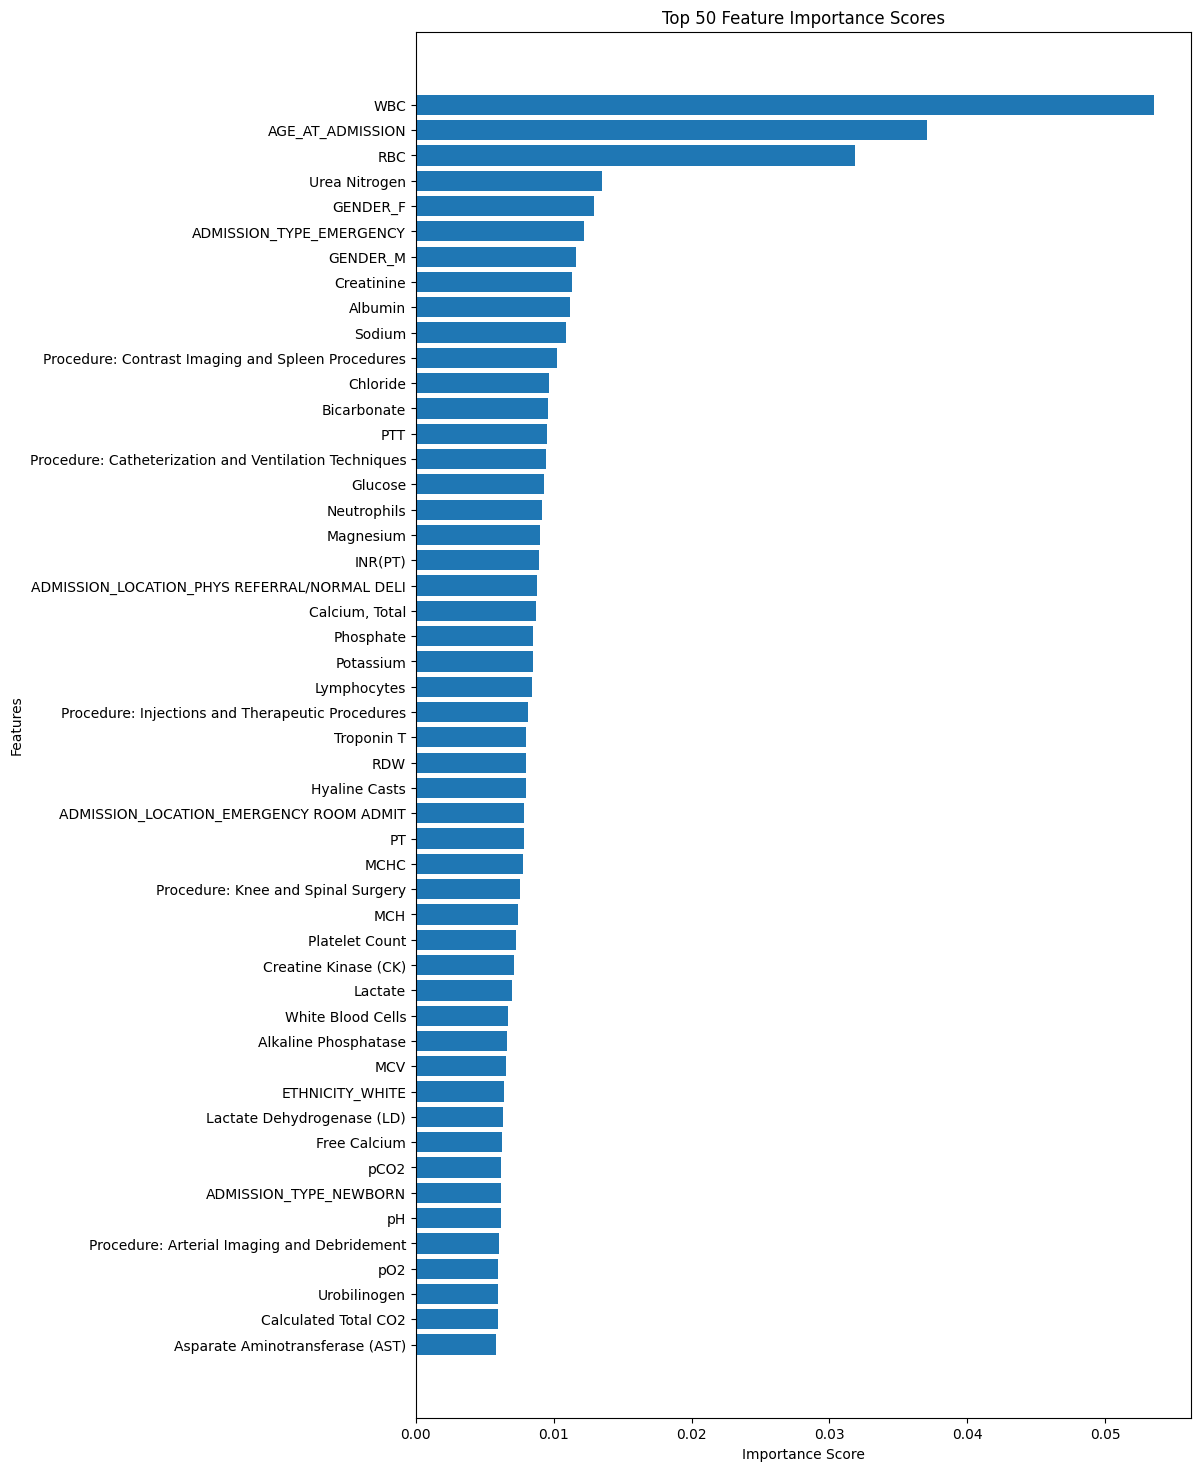

In [8]:
# Train Test Split
X = result.drop('uti', axis=1)
y = result['uti']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature Importance
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top 50 features
sorted_indices = np.argsort(importances)[-50:]

# Plot the top features
plt.figure(figsize=(10,18))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


In [9]:
# Model Evaluation
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.64      0.72       870
         1.0       0.76      0.89      0.82      1130

    accuracy                           0.78      2000
   macro avg       0.79      0.76      0.77      2000
weighted avg       0.79      0.78      0.78      2000



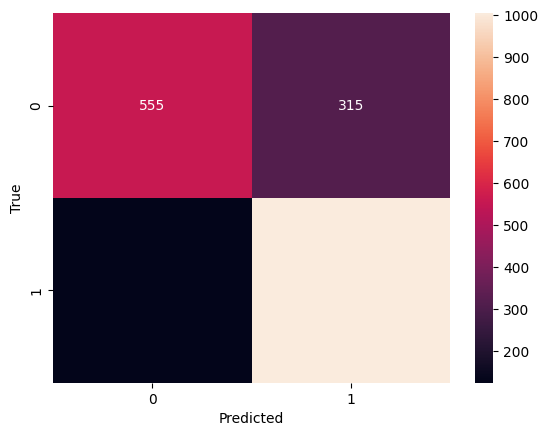

In [10]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

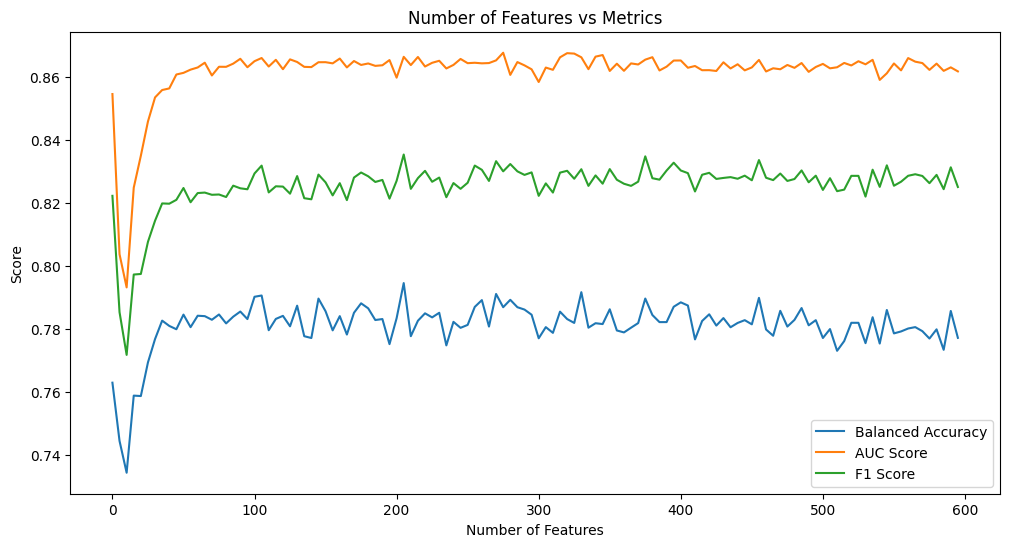

In [11]:
### ROC Pred Proba

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_

# Initialize lists to store metrics
balanced_accuracies = []
auc_scores = []
f1_scores = []

# Initialize list to store feature counts
feature_counts = []

# Sort feature importances
sorted_indices = np.argsort(importances)

for num_features in range(0, 600, 5):
    # Get top features
    top_features = [features[i] for i in sorted_indices[-num_features:]]

    # Select the features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Train Random Forest Classifier
    clf = RandomForestClassifier()
    clf.fit(X_train_selected, y_train)

    # Evaluate the model using balanced accuracy
    y_pred = clf.predict(X_test_selected)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Evaluate the model using F1 score
    f1 = f1_score(y_test, y_pred)

    # Evaluate the model using AUC-ROC with predict_proba
    y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Store the metrics and feature count
    balanced_accuracies.append(balanced_accuracy)
    auc_scores.append(auc_score)
    f1_scores.append(f1)
    feature_counts.append(num_features)

# Create the plot
plt.figure(figsize=(12, 6))

# Plotting Balanced Accuracy
plt.plot(feature_counts, balanced_accuracies, label='Balanced Accuracy')

# Plotting AUC Score
plt.plot(feature_counts, auc_scores, label='AUC Score')

# Plotting F1 Score
plt.plot(feature_counts, f1_scores, label='F1 Score')

plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Number of Features vs Metrics')
plt.legend()

plt.show()


### Get top 500 features selected from the Random Forest Model

In [13]:
all_features_df = pd.read_csv('all_features_df.csv')

In [14]:
# Get the indices of the top 500 features
sorted_indices = np.argsort(importances)[-150:]

# Create a list of the top 500 features
top_150_features = []
for i in sorted_indices:
    top_150_features.append(features[i])

all_features_df.shape
# Create a list of the top 500 features and the column name 'uti'
features_to_select = top_150_features + ['uti']

# Select the features from the all_encoded_df dataframe
selected_features_150 = all_features_df[features_to_select]

# Print the shape of the selected_features_df dataframe
selected_features_150.shape

(10000, 151)

In [15]:
selected_features_150

corynebacterium sp diphtheroids  Total Protein, CSF  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 0.0                 0.0   
3                                 0.0                 0.0   
4                                 0.0                 0.0   
...                               ...                 ...   
9995                              0.0                 0.0   
9996                              0.0                 0.0   
9997                              0.0                 0.0   
9998                              0.0                 0.0   
9999                              0.0                 0.0   

      Procedure: Aspiration and Organ Repair  HAS_CHARTEVENTS_DATA  \
0                                        0.0                     1   
1                                        0.0                     1   
2                                        0.0                     1   
3                                        0.0                     1   
4                                        0.0                     1   
...                                      ...                   ...   
9995                                     0.0                     1   
9996                                     0.0                     1   
9997                                     0.0                     1   
9998                                     0.0                     0   
9999                                     0.0                     1   

      Troponin I  Procedure: Joint Dislocation and Hand Surgery  RBC, CSF  \
0            0.0                                            0.0       0.0   
1            0.0                                            0.0       0.0   
2            0.0                                            0.0       0.0   
3            0.0                                            0.0       0.0   
4            1.0                                            0.0       0.0   
...          ...                                            ...       ...   
9995         0.0                                            0.0       0.0   
9996         0.0                                            0.0       0.0   
9997         0.0                                            0.0       0.0   
9998         0.0                                            0.0       0.0   
9999         0.0                                            0.0       0.0   

      DIAGNOSIS_CONGESTIVE HEART FAILURE    R  Uric Acid  \
0                                  False  0.0        1.0   
1                                  False  0.0        0.0   
2                                  False  0.0        0.0   
3                                  False  0.0        0.0   
4                                  False  0.0        0.0   
...                                  ...  ...        ...   
9995                               False  0.0        0.0   
9996                               False  0.0        0.0   
9997                               False  0.0        0.0   
9998                               False  0.0        0.0   
9999                               False  0.0        0.0   

      clostridium difficile  \
0                       0.0   
1                       0.0   
2                       0.0   
3                       0.0   
4                       0.0   
...                     ...   
9995                    0.0   
9996                    0.0   
9997                    0.0   
9998                    0.0   
9999                    0.0   

      Procedure: Pancreatic and Bronchial Interventions  \
0                                                   0.0   
1                                                   0.0   
2                                                   0.0   
3                                                   0.0   
4                                                   0.0   
...                                                 ...   


In [16]:
# Save the Random Forest Selected 500 Top Features for Model Training
selected_features_150.to_csv('selected_features_150.csv', index=False)